In [1]:
!pip install gdown
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')

nltk.download('wordnet')

file_id = '1HEs4P-tQMKwEMz8i7rT0stlIhl0f-gCU'  # your actual file ID
url = 'https://drive.google.com/uc?id=1HEs4P-tQMKwEMz8i7rT0stlIhl0f-gCU'
output = 'train.csv'  # or whatever your file name is

gdown.download(url, output, quiet=False)

# Load the file (assuming it's a CSV)
import pandas as pd
df_train = pd.read_csv('train.csv')

# Display the first few rows of the dataset
print(df_train.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
Downloading...
From: https://drive.google.com/uc?id=1HEs4P-tQMKwEMz8i7rT0stlIhl0f-gCU
To: /content/train.csv
100%|██████████| 68.8M/68.8M [00:01<00:00, 44.3MB/s]


                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [2]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
df_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df_train.isnull().sum()

,0
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


In [5]:
all_labels=['toxic','severe_toxic','obscene','threat','insult','identity_hate']

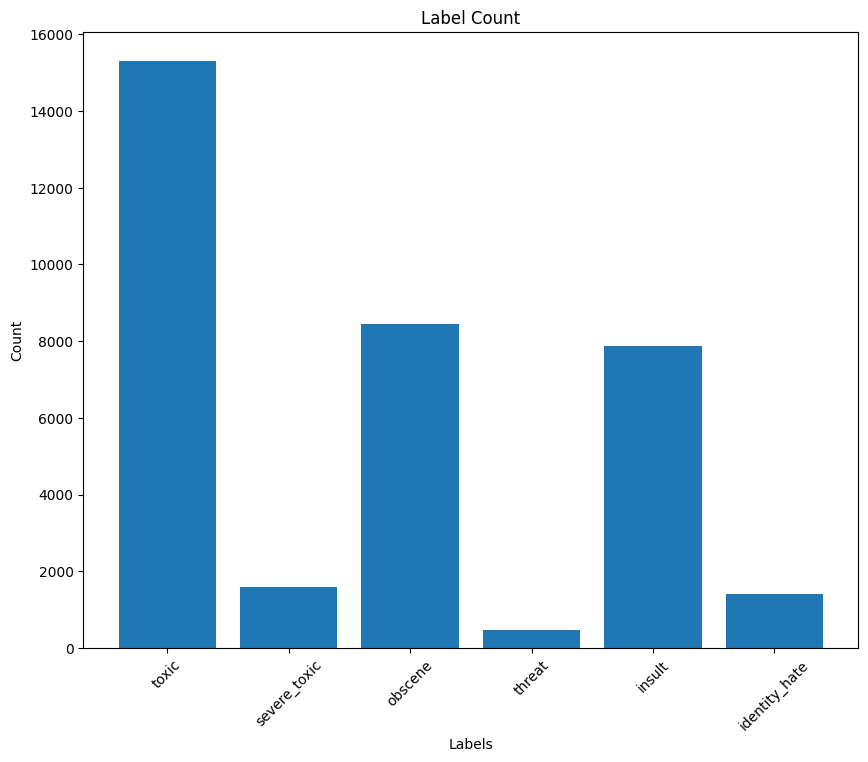

In [6]:
# Sum each label across all rows to get the count for each label
label_counts = df_train[all_labels].sum()

plt.figure(figsize=(10,8))
plt.bar(x=all_labels, height=label_counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Count')
plt.xticks(rotation=45)
plt.show()


In [7]:
df_train[(df_train['toxic']!=1) & ((df_train['severe_toxic']==1)|(df_train['obscene']==1) | (df_train['threat']==1) | (df_train['insult']==1) | (df_train['identity_hate']==1) )]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
179,006d11791d76b9f3,"REPLY ABOVE:\nThat was me, loser. The UN defin...",0,0,0,0,1,0
527,01625cc84c6ef15b,How do you know he is dead. Its just his plan...,0,0,1,0,0,0
662,01ccf4d20d31dfbe,Hebrew Name of Lydia \nAppologies to Til Eulen...,0,0,0,0,1,0
1232,0350c82d1f207e0e,Bleh. I'm all out of ideas. Is there really so...,0,0,1,0,0,0
1351,03aec26f9b6f9ba3,"""\n\n Stop. \n\nStop redirecting the Teddygodz...",0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
158615,f0b46600c7cf2515,"""""""And at least Castro was trying to liberate ...",0,0,1,0,1,0
158793,f3d62179cdb93e58,"Hey FayssalFag, will you ever get a life offli...",0,0,1,0,1,0
158933,f60a9bd97d717630,Administratore: I need your help to stop DIREK...,0,0,0,0,1,0
159103,f896893958bb1cec,"OH DEAR OH DEAR, HOW FUKIN SAD. I WILL REGRET ...",0,0,1,0,0,0


In [8]:
# Here I can see that the the comments that are not clssified as toxic are classified as obscene, threadtm insult and identity hate

In [9]:
df_train[(df_train['toxic']!=1) & (df_train['severe_toxic']==1)]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


In [10]:
# Also toxic comment are severe_toxic. So I'll be dropping this column

In [11]:
df_train[(df_train['toxic']==1) | (df_train['severe_toxic']==1)|(df_train['obscene']==1) | (df_train['threat']==1) | (df_train['insult']==1) | (df_train['identity_hate']==1) ]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0


In [12]:
df_train[(df_train['toxic']!=1) & (df_train['threat']==1)]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
3712,09eb7d87b8c24ca5,Please stop. If you continue to ignore our pol...,0,0,0,1,0,0
6316,10dcd8f485bd06f4,"""\n\n Lock Down \n\nI don't know about the """"B...",0,0,1,1,0,0
16939,2cb0ead532923065,That's funny. You was personally offended? So ...,0,0,0,1,0,0
17210,2d6e671ffae726a3,Wow dude. As your physician I suggest you sli...,0,0,0,1,0,0
23374,3dbae03a5f33e414,hey!!!!!!! thank you for re-editing my contrib...,0,0,0,1,1,0
29295,4db479fe05e88395,Regarding your passing \n\nBecause you willful...,0,0,0,1,0,0
48209,80e0b91bdea43fd3,personal attacks \n\ndont tell me what i can a...,0,0,0,1,0,0
51307,8947f2c12aea0a32,"If no-one beats me to it, I'll knock something...",0,0,0,1,0,0
53841,8fd45641216fdfde,Wikistalking \n\nUnless you wish to be targete...,0,0,0,1,0,0
56561,971494c52942a6cc,"Our warning to you ,Weare not afraid of you b...",0,0,0,1,0,0


In [13]:
df_train['Non-toxic']=0

In [14]:
# Corrected assignment
df_train.loc[(df_train['toxic'] == 0) &
             (df_train['severe_toxic'] == 0) &
             (df_train['obscene'] == 0) &
             (df_train['threat'] == 0) &
             (df_train['insult'] == 0) &
             (df_train['identity_hate'] == 0), 'Non-toxic'] = 1

In [15]:
df_train[df_train['Non-toxic']==1]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Non-toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,1
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,1
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,1
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,1


In [16]:
all_labels=['toxic','severe_toxic','obscene','threat','insult','identity_hate','Non-toxic']

In [17]:
label_counts = df_train[all_labels].sum()
label_counts

,0
toxic,15294
severe_toxic,1595
obscene,8449
threat,478
insult,7877
identity_hate,1405
Non-toxic,143346


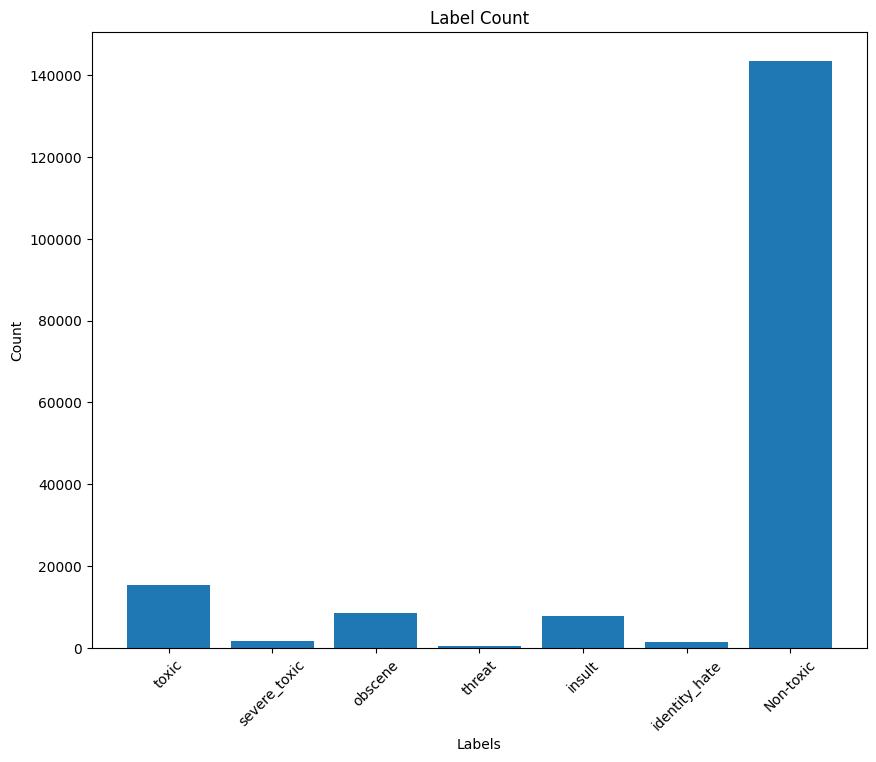

In [18]:
# Sum each label across all rows to get the count for each label


plt.figure(figsize=(10,8))
plt.bar(x=all_labels, height=label_counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Count')
plt.xticks(rotation=45)
plt.show()


In [19]:
df_train['comment_text'].count()

np.int64(159571)

In [20]:
text_data=df_train['comment_text']

In [21]:
text_data

,comment_text
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember..."
...,...
159566,""":::::And for the second time of asking, when ..."
159567,You should be ashamed of yourself \n\nThat is ...
159568,"Spitzer \n\nUmm, theres no actual article for ..."
159569,And it looks like it was actually you who put ...


In [22]:
comment_length=text_data.apply(len)

In [23]:
comment_length

,comment_text
0,264
1,112
2,233
3,622
4,67
...,...
159566,295
159567,99
159568,81
159569,116


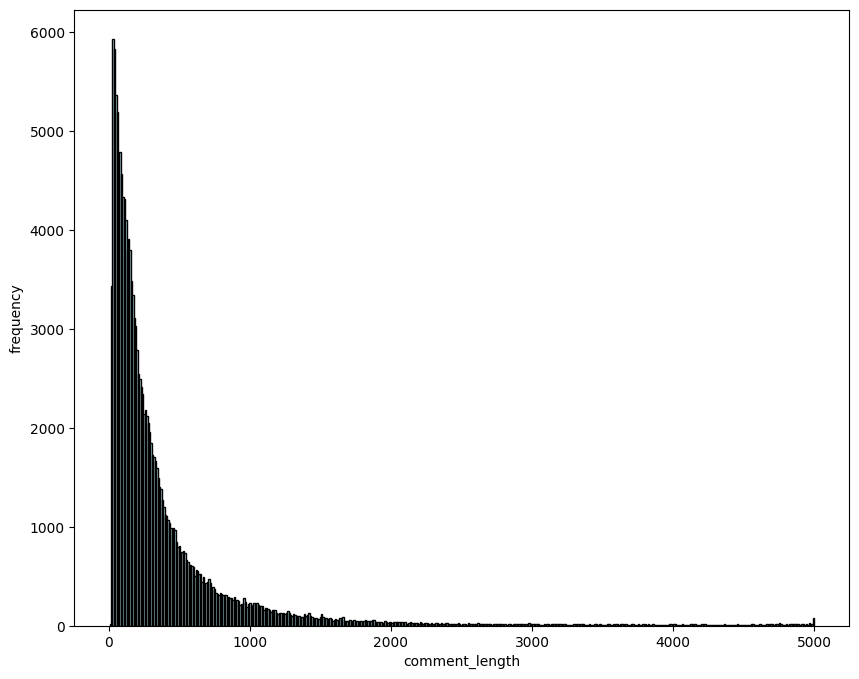

In [24]:
plt.figure(figsize=(10,8))
plt.hist(x=comment_length,bins=500,color='lightblue',edgecolor='black')
plt.xlabel('comment_length')
plt.ylabel('frequency')
plt.show()

In [25]:
# Setting new tooxicity for the columns to store the data for all type of toxicity
# Corrected assignment
df_train['all_kind_of_toxic']=0
df_train.loc[df_train['Non-toxic']==0,'all_kind_of_toxic']=1

<BarContainer object of 2 artists>

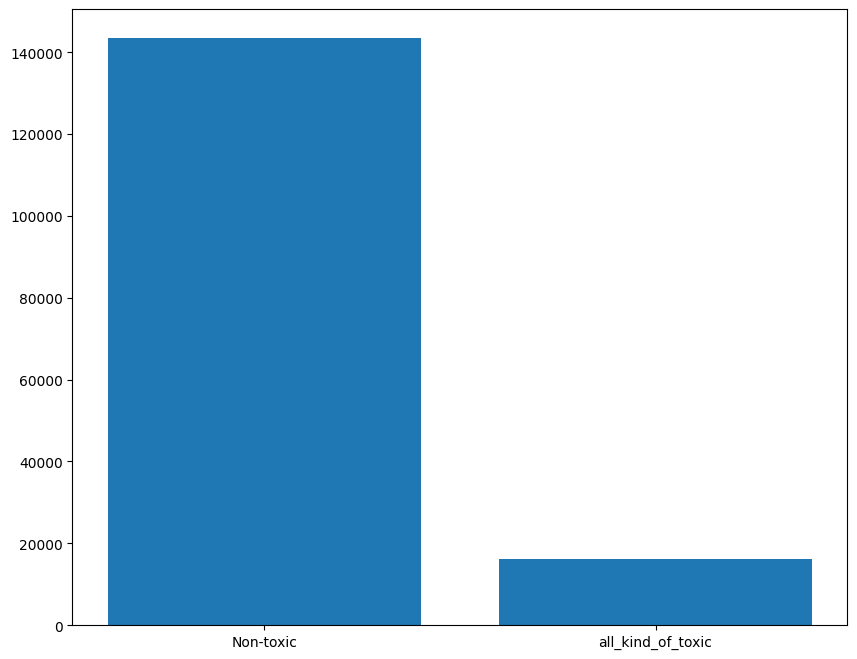

In [26]:
counts = df_train[['Non-toxic', 'all_kind_of_toxic']].sum()
plt.figure(figsize=(10,8))
plt.bar(x=counts.index,height=counts)

In [27]:
df_train[df_train['all_kind_of_toxic']==1]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Non-toxic,all_kind_of_toxic
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0,1
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,0,1
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,0,1
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,0,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1,0,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,0,1
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0,0,1
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0,0,1


In [28]:
X=df_train['comment_text']
y=df_train['all_kind_of_toxic']

In [29]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess(row):
    row = row.lower()
    row = re.sub(r'[^\w\s]', '', row)
    words = row.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words) if words else 'empty'



In [30]:
def get_features(X_train,train_data=False):
    X=[]
    for row in X_train:
        row=preprocess(row)
        X.append(row)
    if(train_data==True):
        X_tfidf=tfidf.fit_transform(X)
    else:
        X_tfidf=tfidf.transform(X)
    return X_tfidf



In [31]:
def train_model(X_train,y_train,model):
    X=get_features(X_train,train_data=True)
    model.fit(X,y_train)
    return model

In [32]:
X_train,X_test,y_train,y_pred=train_test_split(X,y,test_size=0.3,train_size=0.7)
tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1, 2))
LR_model=LogisticRegression(random_state=42,max_iter=1000,class_weight='balanced',C=2)
model=train_model(X_train,y_train,LR_model)

In [33]:
def model_predict(trained_model,X_test,y_test):
    X=get_features(X_test,train_data=False)
    predictions=trained_model.predict(X)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    cm=confusion_matrix(y_test,predictions)
    # Print metrics for analysis
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(cm)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    print(tn, fp, fn, tp)
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="RdPu", xticklabels=["all_kind_of_toxic", "Non-toxic"], yticklabels=["all_kind_of_toxic", "Non-toxic"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

Accuracy: 0.95
Precision: 0.70
Recall: 0.83
F1 Score: 0.76
[[41220  1717]
 [  858  4077]]
41220 1717 858 4077


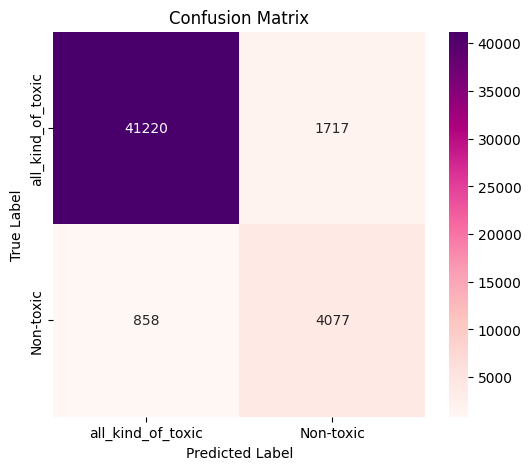

In [34]:
model_predict(model,X_test,y_pred)

In [35]:
#X_train,X_test,y_train,y_pred=train_test_split(X,y,test_size=0.3,train_size=0.7)
#tfidf = TfidfVectorizer(stop_words='english')
nb=MultinomialNB()
model=train_model(X_train,y_train,nb)

Accuracy: 0.91
Precision: 1.00
Recall: 0.09
F1 Score: 0.17
[[42937     0]
 [ 4490   445]]
42937 0 4490 445


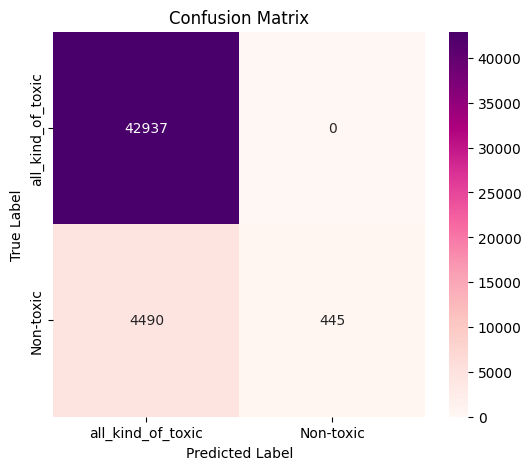

In [36]:
model_predict(model,X_test,y_pred)

Downloading...
From (original): https://drive.google.com/uc?id=1HcQZI_3vvFn6AxXG-mbvnYPU63s86VZN
From (redirected): https://drive.google.com/uc?id=1HcQZI_3vvFn6AxXG-mbvnYPU63s86VZN&confirm=t&uuid=39c2ec60-b60d-4b3f-b928-0e3b6dd1d48a
To: /content/combined_toxic_comments.csv
100%|██████████| 671M/671M [00:07<00:00, 94.8MB/s]


                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...    0.0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...    0.0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...    0.0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...    0.0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...    0.0   

   severe_toxic  obscene  threat  insult  identity_hate    source  
0           0.0      0.0     0.0     0.0            0.0  original  
1           0.0      0.0     0.0     0.0            0.0  original  
2           0.0      0.0     0.0     0.0            0.0  original  
3           0.0      0.0     0.0     0.0            0.0  original  
4           0.0      0.0     0.0     0.0            0.0  original  
Missing values in comment_text: 223

Class distribution:
is_toxic
0    1839023
1     125199
Name: count, 

Text(0, 0.5, 'Count')

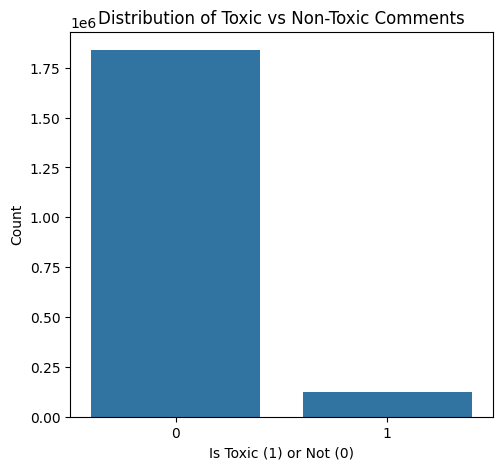

In [37]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load the combined dataset
import gdown
url = 'https://drive.google.com/uc?id=1HcQZI_3vvFn6AxXG-mbvnYPU63s86VZN'
output = 'combined_toxic_comments.csv'
gdown.download(url, output, quiet=False)

df = pd.read_csv('combined_toxic_comments.csv', dtype={'id': str})

# Display the first few rows of the dataset
print(df.head())

# 1. Handle missing values
print(f"Missing values in comment_text: {df['comment_text'].isna().sum()}")
df = df.dropna(subset=['comment_text'])  # Drop rows with missing comments

# 2. Combine all toxicity labels into a single binary label
toxic_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df['is_toxic'] = df[toxic_cols].max(axis=1)
df['is_toxic'] = df['is_toxic'].apply(lambda x: 1 if x > 0.5 else 0)

# 3. Clean text data - ensure all entries are strings
df['comment_text'] = df['comment_text'].astype(str)

# Check class distribution
print("\nClass distribution:")
print(df['is_toxic'].value_counts())

# Plot class distribution
plt.figure(figsize=(12, 5))

# Plot 1: Distribution of Toxic vs Non-Toxic Comments
plt.subplot(1, 2, 1)
sns.countplot(x='is_toxic', data=df)
plt.title('Distribution of Toxic vs Non-Toxic Comments')
plt.xlabel('Is Toxic (1) or Not (0)')
plt.ylabel('Count')

<ipython-input-38-c36d282e903d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=toxic_counts.values, y=toxic_counts.index, palette='viridis')


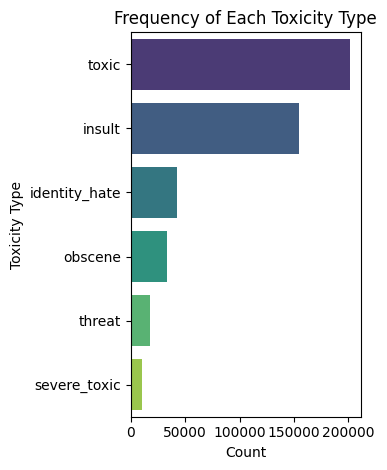

In [38]:
# Plot 2: Frequency of each toxicity type
plt.subplot(1, 2, 2)
toxic_counts = df[toxic_cols].sum().sort_values(ascending=False)
sns.barplot(x=toxic_counts.values, y=toxic_counts.index, palette='viridis')
plt.title('Frequency of Each Toxicity Type')
plt.xlabel('Count')
plt.ylabel('Toxicity Type')

plt.tight_layout()
plt.show()

In [39]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['comment_text'], df['is_toxic'],
    test_size=0.2,
    random_state=42,
    stratify=df['is_toxic']
)

In [40]:

# TF-IDF Vectorization with error handling
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    decode_error='replace'  # Handle encoding issues
)

try:
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
except Exception as e:
    print(f"Error during vectorization: {e}")
    # Additional debug: print problematic samples
    problematic = [doc for doc in X_train if not isinstance(doc, str)]
    print(f"Number of non-string documents: {len(problematic)}")
    raise

In [41]:
# Function to evaluate models
def evaluate_model(model, X_test_vec, y_test, model_name):
    y_pred = model.predict(X_test_vec)
    y_proba = model.predict_proba(X_test_vec)[:, 1]  # Probability of positive class

    print(f"\n=== {model_name} Evaluation ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Toxic', 'Toxic'],
                yticklabels=['Non-Toxic', 'Toxic'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Frequency graph of predicted probabilities
    plt.figure(figsize=(8, 6))
    plt.hist(y_proba, bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Frequency of Predicted Probabilities - {model_name}')
    plt.xlabel('Predicted Probability of Toxicity')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()

    return y_proba


Training Naive Bayes model...

=== Naive Bayes Evaluation ===
Accuracy: 0.9430156932123357
Classification Report:
               precision    recall  f1-score   support

           0     0.9428    0.9998    0.9705    367805
           1     0.9739    0.1089    0.1959     25040

    accuracy                         0.9430    392845
   macro avg     0.9584    0.5544    0.5832    392845
weighted avg     0.9448    0.9430    0.9211    392845



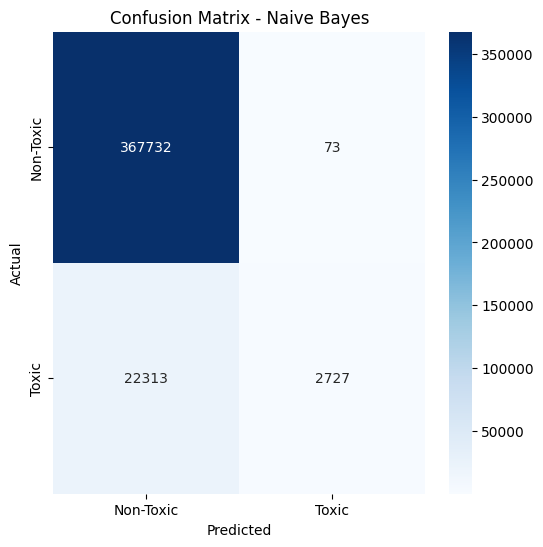

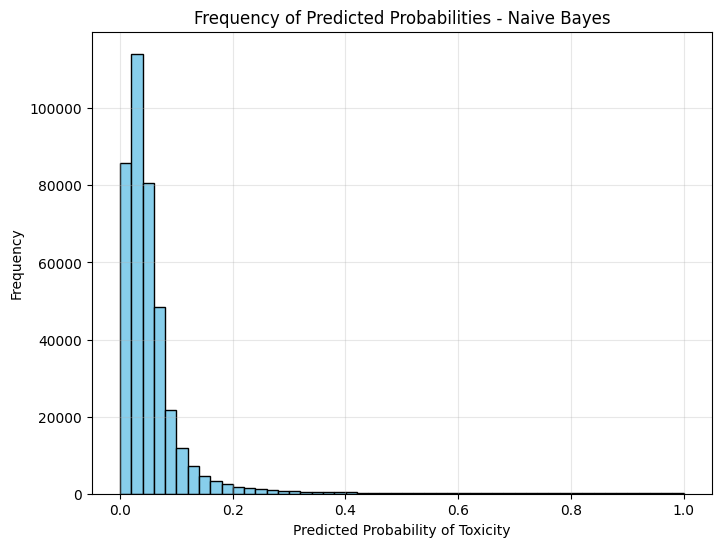

In [42]:

# ================================
# Model 1: Naive Bayes
# ================================
print("\nTraining Naive Bayes model...")
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
nb_proba = evaluate_model(nb_model, X_test_vec, y_test, "Naive Bayes")



Training Logistic Regression model...

=== Logistic Regression Evaluation ===
Accuracy: 0.957123038348458
Classification Report:
               precision    recall  f1-score   support

           0     0.9631    0.9922    0.9774    367805
           1     0.7945    0.4415    0.5676     25040

    accuracy                         0.9571    392845
   macro avg     0.8788    0.7169    0.7725    392845
weighted avg     0.9523    0.9571    0.9513    392845



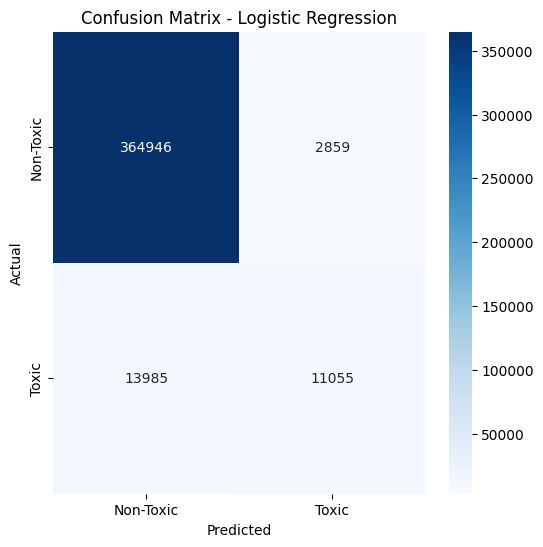

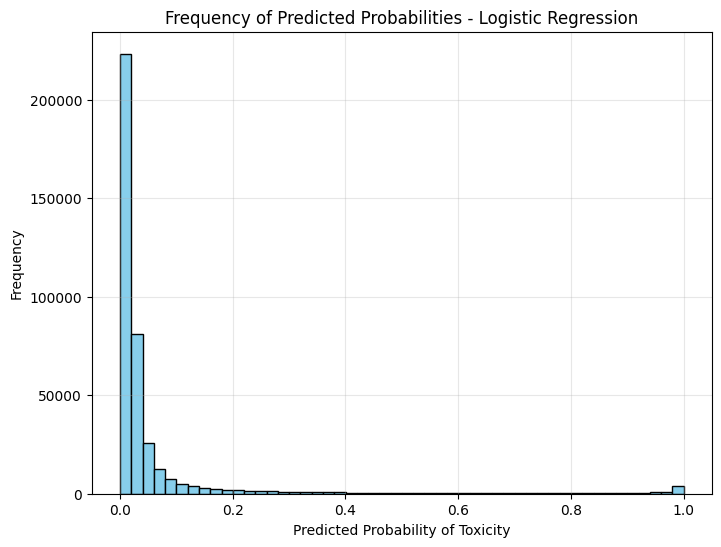

In [43]:
# ================================
# Model 2: Logistic Regression
# ================================
print("\nTraining Logistic Regression model...")
lr_model = LogisticRegression(max_iter=1000, solver='liblinear')
lr_model.fit(X_train_vec, y_train)
lr_proba = evaluate_model(lr_model, X_test_vec, y_test, "Logistic Regression")


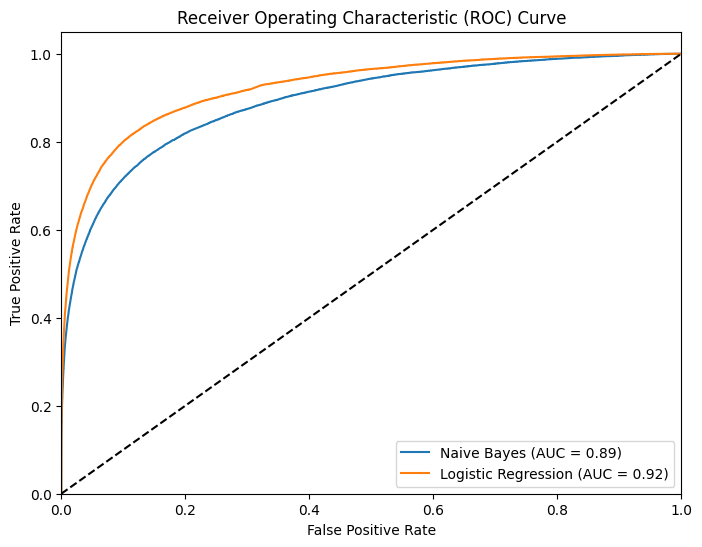

In [44]:
# Plot ROC curves for both models
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))
for model, proba, name in [(nb_model, nb_proba, 'Naive Bayes'),
                          (lr_model, lr_proba, 'Logistic Regression')]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [47]:
# Step 1: Download files
import gdown

aave_file_id = '1QQKL_vTUluF3MNK9jsWmwLl0s7B3VFcc'  # <-- replace with actual ID
sae_file_id = '1TiJZyGMPEbVGZFdAqksXjMrSaPfnPwwS'    # <-- replace with actual ID

gdown.download(f'https://drive.google.com/uc?id={aave_file_id}', 'aave_samples.txt', quiet=False)
gdown.download(f'https://drive.google.com/uc?id={sae_file_id}', 'sae_samples.txt', quiet=False)

# Step 2: Read files
with open('aave_samples.txt', 'r') as file:
    aave_texts = [line.strip() for line in file if line.strip()]

with open('sae_samples.txt', 'r') as file:
    sae_texts = [line.strip() for line in file if line.strip()]


Downloading...
From: https://drive.google.com/uc?id=1QQKL_vTUluF3MNK9jsWmwLl0s7B3VFcc
To: /content/aave_samples.txt
100%|██████████| 203k/203k [00:00<00:00, 89.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TiJZyGMPEbVGZFdAqksXjMrSaPfnPwwS
To: /content/sae_samples.txt
100%|██████████| 228k/228k [00:00<00:00, 99.8MB/s]


In [48]:

# Step 3: Predict using existing models
for model_name, model in [('Naive Bayes', nb_model), ('Logistic Regression', lr_model)]:
    print(f"\nModel: {model_name}")
    for dataset_name, texts in {'AAVE': aave_texts, 'SAE': sae_texts}.items():
        X_unseen = vectorizer.transform(texts) # This line was changed
        preds = model.predict(X_unseen)
        print(f"Predictions for {dataset_name}:")
        print(pd.Series(preds).value_counts())


Model: Naive Bayes
Predictions for AAVE:
0    1805
1     214
Name: count, dtype: int64
Predictions for SAE:
0    1823
1     196
Name: count, dtype: int64

Model: Logistic Regression
Predictions for AAVE:
0    1637
1     382
Name: count, dtype: int64
Predictions for SAE:
0    1677
1     342
Name: count, dtype: int64



Naive Bayes on AAVE
Accuracy: 0.8940069341258049
Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       1.00      0.89      0.94      2019
       Toxic       0.00      0.00      0.00         0

    accuracy                           0.89      2019
   macro avg       0.50      0.45      0.47      2019
weighted avg       1.00      0.89      0.94      2019



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


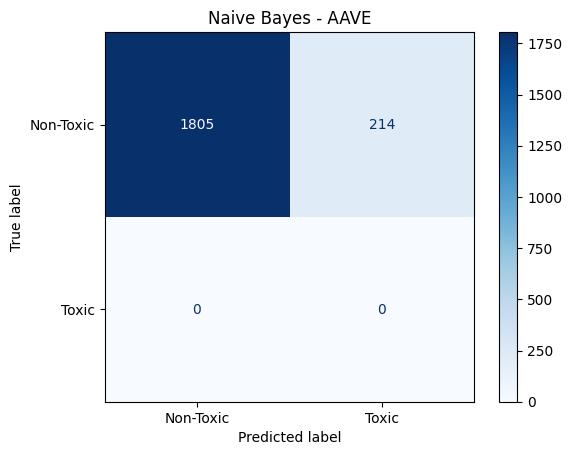


Naive Bayes on SAE
Accuracy: 0.9029222387320456
Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       1.00      0.90      0.95      2019
       Toxic       0.00      0.00      0.00         0

    accuracy                           0.90      2019
   macro avg       0.50      0.45      0.47      2019
weighted avg       1.00      0.90      0.95      2019



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


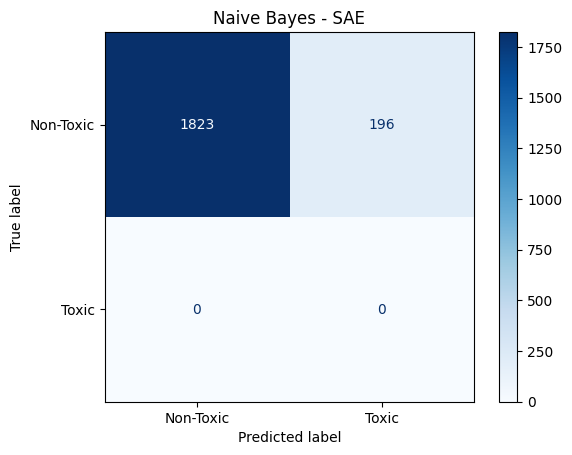


Logistic Regression on AAVE
Accuracy: 0.8107974244675582
Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       1.00      0.81      0.90      2019
       Toxic       0.00      0.00      0.00         0

    accuracy                           0.81      2019
   macro avg       0.50      0.41      0.45      2019
weighted avg       1.00      0.81      0.90      2019



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


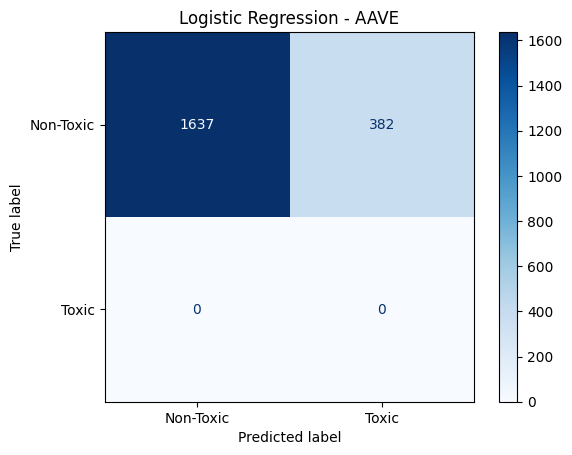


Logistic Regression on SAE
Accuracy: 0.8306092124814265
Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       1.00      0.83      0.91      2019
       Toxic       0.00      0.00      0.00         0

    accuracy                           0.83      2019
   macro avg       0.50      0.42      0.45      2019
weighted avg       1.00      0.83      0.91      2019



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


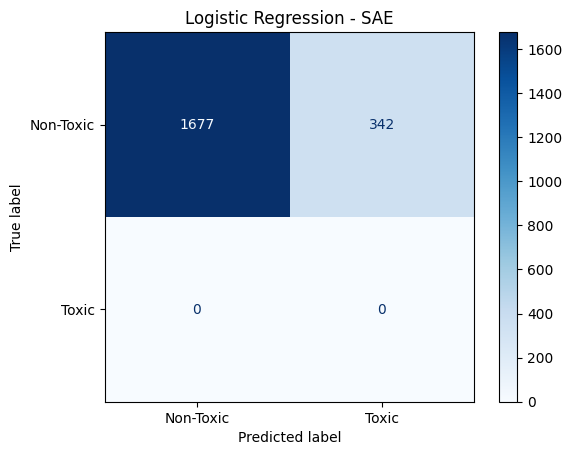

In [4]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

# Simulated true/predicted labels
# AAVE
y_true_aave = [0] * (1805 + 214)  # assume all true labels are 0
y_pred_aave_nb = [0]*1805 + [1]*214
y_pred_aave_lr = [0]*1637 + [1]*382

# SAE
y_true_sae = [0] * (1823 + 196)
y_pred_sae_nb = [0]*1823 + [1]*196
y_pred_sae_lr = [0]*1677 + [1]*342

# Evaluation function
def evaluate(y_true, y_pred, model, dataset):
    print(f"\n{model} on {dataset}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Non-Toxic", "Toxic"]))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Toxic", "Toxic"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{model} - {dataset}")
    plt.show()

# Run evaluations
evaluate(y_true_aave, y_pred_aave_nb, "Naive Bayes", "AAVE")
evaluate(y_true_sae, y_pred_sae_nb, "Naive Bayes", "SAE")
evaluate(y_true_aave, y_pred_aave_lr, "Logistic Regression", "AAVE")
evaluate(y_true_sae, y_pred_sae_lr, "Logistic Regression", "SAE")
